In [5]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import FlagserPersistence, VietorisRipsPersistence
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram

In [6]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def load_all_games(data_dir: str) -> List[List[Dict]]:
    all_games = []
    goal_counts = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            game = load_game_data(file_path)
            all_games.append(game)
            goal_counts.append(int(filename.split('_')[-1]) / int(filename.split('_')[-2]))
    return all_games, goal_counts

In [7]:
def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"])
    min_count = min(pass_info["count"] for player in game for pass_info in player["passes"])

    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]

            edge_weight = 1 - (count - min_count) / (max_count - min_count)

            G.add_edge(player1, player2, weight=edge_weight)

    return G

def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights = [G[u][v]['weight'] * 5 for u, v in G.edges()] 
    plt.figure(figsize=(10, 8))
    
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray')
    
    plt.title("Passing Network Graph (Normalized Edge Weights)")
    plt.axis('off')
    plt.show()
    

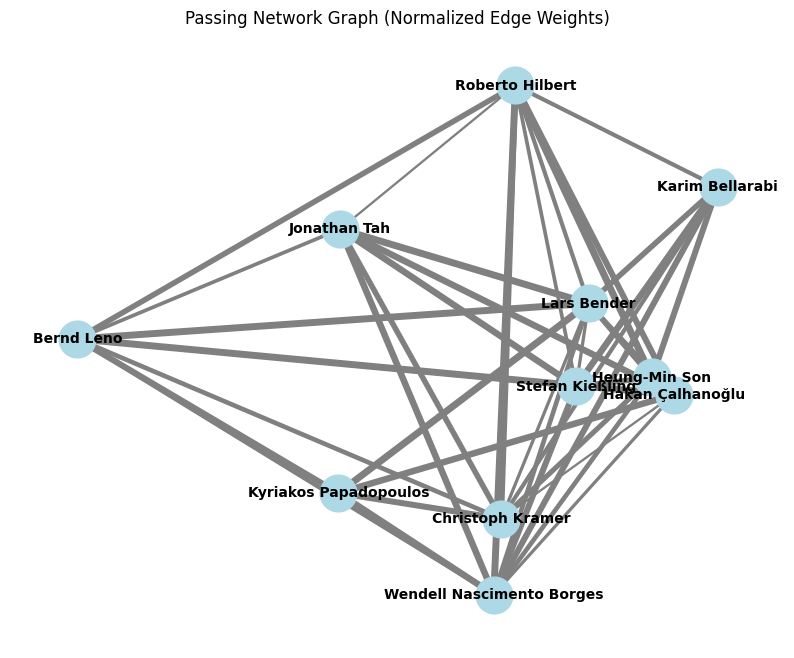

In [8]:
example_game = load_game_data('./data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [9]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [10]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[0.         0.66666667 1.                inf 0.53333333        inf
  0.86666667 1.         0.8        0.6        0.6       ]
 [0.66666667 0.         0.33333333 0.73333333 0.8        0.6
  0.86666667 0.46666667 0.8               inf        inf]
 [1.         0.33333333 0.         0.73333333 0.93333333        inf
  0.93333333 0.6        0.86666667 0.26666667 0.46666667]
 [       inf 0.73333333 0.73333333 0.                inf 0.86666667
         inf 0.8        1.         0.8        0.66666667]
 [0.53333333 0.8        0.93333333        inf 0.                inf
         inf 1.         0.33333333 0.93333333 0.93333333]
 [       inf 0.6               inf 0.86666667        inf 0.
         inf 0.8        0.6        0.93333333 0.86666667]
 [0.86666667 0.86666667 0.93333333        inf        inf        inf
  0.         1.                inf        inf 0.93333333]
 [1.         0.46666667 0.6        0.8        1.         0.8
  1.         0.         0.6        0.46666667 0.666666

In [11]:
# persistence = FlagserPersistence()
persistence = VietorisRipsPersistence(metric="precomputed", homology_dimensions=[0, 1])

diagrams = persistence.fit_transform([adj_matrix])[0]
plot_diagram(diagrams)